In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, TargetEncoder, FunctionTransformer, OneHotEncoder, LabelEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import set_config

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from lightgbm import LGBMClassifier, early_stopping, plot_importance as lgb_plot_importance
from xgboost import XGBClassifier, plot_importance as xgb_plot_importance
from xgboost.callback import EarlyStopping

from bayes_opt import BayesianOptimization

import torch
import shap

set_config(transform_output="pandas")

warnings.filterwarnings('ignore')

In [28]:
train = pd.read_csv("dataset/Train.csv")
test  = pd.read_csv("dataset/Test.csv")
indicator = pd.read_csv("dataset/economic_indicators.csv")

X, y = train.drop(columns='target'), train['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Data Preprocessing

In [29]:
def feature_exctraction(df, indicator):

    df = df.copy()

    # Discrete features
    df[['disbursement_year', 'disbursement_month', 'disbursement_day']] = df['disbursement_date'].str.split('-', expand=True).astype(np.int64)
    df[['due_year', 'due_month', 'due_day']] = df['due_date'].str.split('-', expand=True).astype(np.int64)
    df['loan_term'] = df['duration'].apply(
        lambda x:
            0 if x <= 14 else
            1 if x <= 30 else
            2 if x <= 365 else
            3
    )
    df['loan_type'] = df['loan_type'].apply(lambda x: x[5:]).astype(np.int64)
    df['New_versus_Repeat'] = df['New_versus_Repeat'].apply(lambda x: 1 if x == "New" else 0)

    # Continuous features
    df["Repay_Rate"] = (df["Total_Amount_to_Repay"] + 1) / (df["Total_Amount"] + 1)
    df["Lender_Repay_Rate"] = (df["Lender_portion_to_be_repaid"] + 1) / (df["Amount_Funded_By_Lender"] + 1)
    df["duration"] = df["duration"].astype(np.float64)

    # Economical indicators
    ind_dict = indicator.set_index(["Country", "Indicator"]).T.to_dict()
    ind_list = ["Inflation, consumer prices (annual %)", "Unemployment rate", "Official exchange rate (LCU per US$, period average)", "Deposit interest rate (%)"]

    for ind in ind_list:
        df[ind] = df.apply(lambda row: ind_dict[(row['country_id'], ind)][f"YR{row['disbursement_year'] - 1}"], axis=1)

    df.rename(columns={
        "Inflation, consumer prices (annual %)": "Inflation",
        "Unemployment rate": "Unemployment",
        "Official exchange rate (LCU per US$, period average)": "Exchange_Rate",
        "Deposit interest rate (%)": "Deposit_interest_rate"
    }, inplace=True)

    # Drop columns
    df = df.drop(columns=[
        'disbursement_date', 'due_date', 'country_id',
        "customer_id", "tbl_loan_id", "ID",
    ])

    return df

exctraction = FunctionTransformer(feature_exctraction, kw_args={"indicator": indicator})


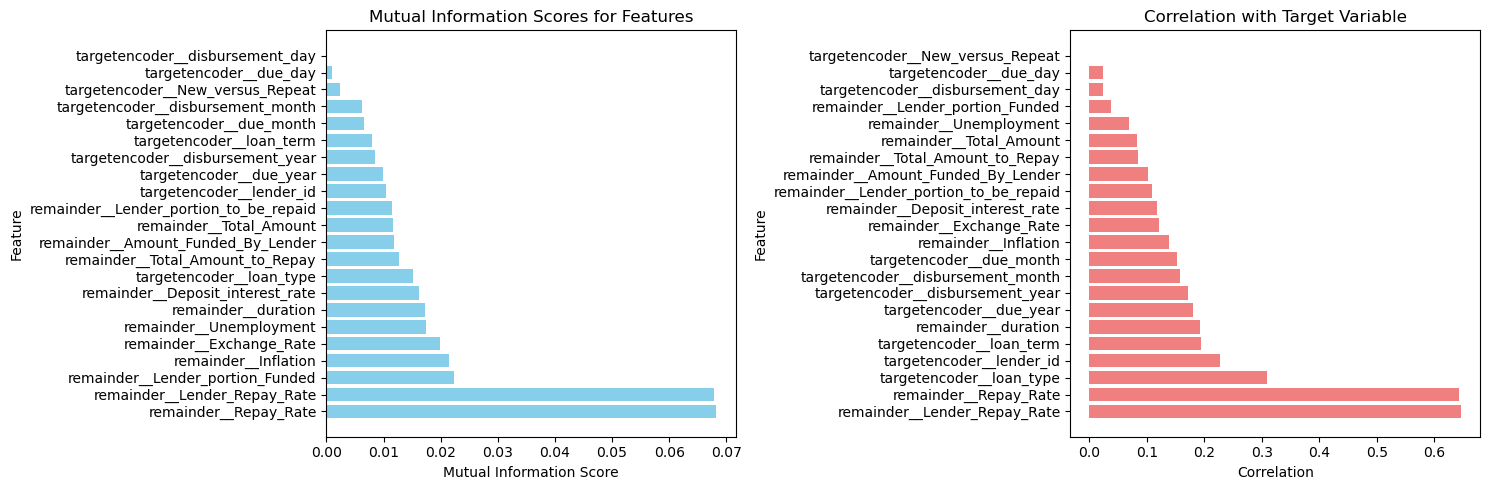

In [30]:
preprocess = make_pipeline(
    exctraction,
    make_column_transformer((TargetEncoder(), make_column_selector(dtype_include='int')), remainder='passthrough')
)

X_trans, y_trans = preprocess.fit_transform(X_train, y_train), y_train

mi_scores = mutual_info_classif(X_trans, y_trans)

mi_scores_df = pd.DataFrame({'Feature': X_trans.columns, 'MI Score': mi_scores})
mi_scores_df = mi_scores_df.sort_values(by='MI Score', ascending=False)

correlation = X_trans.corrwith(y_trans)
correlation_df = pd.DataFrame({'Feature': correlation.index, 'Correlation': correlation.values})
correlation_df = correlation_df.sort_values(by='Correlation', ascending=False)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].barh(mi_scores_df['Feature'], mi_scores_df['MI Score'], color='skyblue')
axs[0].set_xlabel('Mutual Information Score')
axs[0].set_ylabel('Feature')
axs[0].set_title('Mutual Information Scores for Features')

axs[1].barh(correlation_df['Feature'], correlation_df['Correlation'], color='lightcoral')
axs[1].set_xlabel('Correlation')
axs[1].set_ylabel('Feature')
axs[1].set_title('Correlation with Target Variable')

plt.tight_layout()
plt.show()

In [31]:
def feature_selection(df):
    df = df.copy()

    # Continuous columns
    continuous_columns = [
        #'Total_Amount',
        'Total_Amount_to_Repay',
        #'Amount_Funded_By_Lender',
        'Lender_portion_Funded',
        'Lender_portion_to_be_repaid',
        'Repay_Rate',
        #'Lender_Repay_Rate',
        'Inflation',
        #'Unemployment',
        #'Exchange_Rate',
        'duration',
    ]

    # Discrete columns
    discrete_columns = [
        #'country_id',
        #'lender_id',
        #'disbursement_year',
        'disbursement_month',
        #'disbursement_day',
        #'due_year',
        #'due_month',
        #'due_day',
        #'loan_term',
        #'loan_type',
        #'New_versus_Repeat',
        #'Deposit_interest_rate',
    ]

    df = df[continuous_columns + discrete_columns]

    return df


selection = FunctionTransformer(feature_selection)

## Model

### Baseline

In [32]:
model = make_pipeline(
    exctraction,
    selection,
    StandardScaler(),
    LogisticRegression(random_state=42)
)

model.fit(X_train, y_train)

print(f"Train f1-score: {f1_score(y_train, model.predict(X_train))}")
print(classification_report(y_test, model.predict(X_test)))

Train f1-score: 0.5876543209876544
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     13479
           1       0.72      0.47      0.57       252

    accuracy                           0.99     13731
   macro avg       0.85      0.73      0.78     13731
weighted avg       0.99      0.99      0.99     13731



### Models

In [33]:
X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

preprocess = make_pipeline(
    exctraction,
    selection,
    make_column_transformer(
        (FunctionTransformer(lambda x: np.log(x + 1)), make_column_selector(dtype_include=np.float64)),
        (TargetEncoder(), make_column_selector(dtype_include='int')),
        remainder='passthrough'
    )
)

preprocess.fit(X_t, y_t)

opt_params = {
    'max_depth': 10,
    'max_leaves': 0,
    'n_estimators': 2000,
    'learning_rate': 0.05,
    'random_state': 42,
    'verbose': -1,
    'n_jobs': -1,
    'early_stopping_rounds': 10,
    'eval_metric': 'logloss',
}

fit_params = {
    'eval_set': [(preprocess.transform(X_t), y_t), (preprocess.transform(X_v), y_v)],
    'verbose': False
}

model = XGBClassifier(**opt_params)
model.fit(preprocess.transform(X_t), y_t, **fit_params)

threshold = 0.50
model.predict = lambda X: (model.predict_proba(X)[:, 1] > threshold).astype(int)

print(f"Train f1-score: {f1_score(y_t, model.predict(preprocess.transform(X_t)))}")
print(f"Validation f1-score: {f1_score(y_v, model.predict(preprocess.transform(X_v)))}")
print("-" * 10)
print(classification_report(y_test, model.predict(preprocess.transform(X_test))))

Train f1-score: 0.9617074701820465
Validation f1-score: 0.8827930174563591
----------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13479
           1       0.86      0.83      0.85       252

    accuracy                           0.99     13731
   macro avg       0.93      0.92      0.92     13731
weighted avg       0.99      0.99      0.99     13731



### Submission

In [34]:
# Make submission

X_t = preprocess.transform(test)

y_pred = model.predict(X_t)

submission = pd.DataFrame({
    "ID": test["ID"],
    "target": y_pred
})

submission.to_csv("submission.csv", index=False)

---